In [1]:
!pip install xmltodict

import numpy as np
import pandas as pd
import seaborn as sns
import os, json, random
from pathlib import Path
import argparse, glob, tqdm, time
from xml.etree import cElementTree as ElementTree
from xml.dom import minidom
import matplotlib.pyplot as plt
from PIL import Image
import xmltodict
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.patches as mpatches

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Data Import

In [2]:
%cd '/content'

%mkdir RoadDamageDataset 
%cd RoadDamageDataset

# train set
!wget -c https://mycityreport.s3-ap-northeast-1.amazonaws.com/02_RoadDamageDataset/public_data/IEEE_bigdata_RDD2020/train.tar.gz
!tar xf train.tar.gz

/content
/content/RoadDamageDataset
--2022-09-05 07:38:17--  https://mycityreport.s3-ap-northeast-1.amazonaws.com/02_RoadDamageDataset/public_data/IEEE_bigdata_RDD2020/train.tar.gz
Resolving mycityreport.s3-ap-northeast-1.amazonaws.com (mycityreport.s3-ap-northeast-1.amazonaws.com)... 52.219.8.47
Connecting to mycityreport.s3-ap-northeast-1.amazonaws.com (mycityreport.s3-ap-northeast-1.amazonaws.com)|52.219.8.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1472626254 (1.4G) [application/x-tar]
Saving to: ‘train.tar.gz’

train.tar.gz        100%[===================>]   1.37G  22.5MB/s    in 63s     

2022-09-05 07:39:21 (22.2 MB/s) - ‘train.tar.gz’ saved [1472626254/1472626254]



# 2. Image and annotation reading

In [3]:
with open(r'/content/RoadDamageDataset/train/Czech/annotations/xmls/Czech_003560.xml', 'r') as f:
    data = f.read()
d = xmltodict.parse(data)
d

{'annotation': {'folder': 'images',
  'filename': 'Czech_003560.jpg',
  'size': {'depth': '3', 'width': '600', 'height': '600'},
  'object': [{'name': 'D40',
    'bndbox': {'xmin': '99', 'ymin': '406', 'xmax': '172', 'ymax': '434'}},
   {'name': 'D20',
    'bndbox': {'xmin': '267', 'ymin': '413', 'xmax': '409', 'ymax': '532'}},
   {'name': 'D20',
    'bndbox': {'xmin': '1', 'ymin': '430', 'xmax': '196', 'ymax': '519'}}]}}

In [4]:
dict_color = {'D00': 'b',
              'D01': 'b',
              'D10': 'g',
              'D11': 'g',
              'D20': 'r',
              'D40': 'c', 
              'D43': 'm', 
              'D44': 'm', 
              'D50': 'y', 
              'D0w0': 'w'}
dict_defect = {'D00': 'Longitudinal Crack',
               'D01': 'Longitudinal Crack', 
               'D10': 'Transverse Crack', 
               'D11': 'Transverse Crack', 
               'D20': 'Aligator Crack', 
               'D40': 'Pothole', 
               'D43': 'White/Yellow Lines', 
               'D44': 'White/Yellow Lines', 
               'D50': 'Manhole', 
               'D0w0': 'Others'}

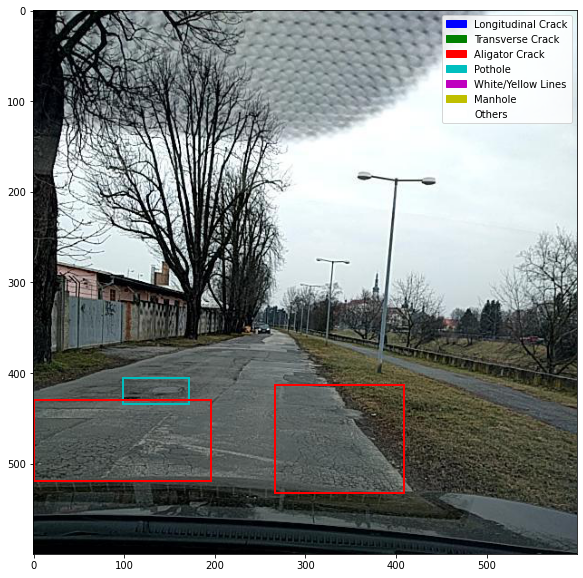

In [5]:
x = np.array(Image.open(r'/content/RoadDamageDataset/train/Czech/images/Czech_003560.jpg'))
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(x)
for i in range(0, len(d['annotation']['object'])):
    defect_type = d['annotation']['object'][i]['name']
    xmin = int(d['annotation']['object'][i]['bndbox']['xmin'])
    xmax = int(d['annotation']['object'][i]['bndbox']['xmax'])
    ymin = int(d['annotation']['object'][i]['bndbox']['ymin'])
    ymax = int(d['annotation']['object'][i]['bndbox']['ymax'])
    ax.add_artist(Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,
                    edgecolor = dict_color[defect_type],
                    label = dict_defect[defect_type],
                    facecolor = 'none',
                    lw = 2))

patches = [mpatches.Patch(color = list(dict_color.values())[i], label="{:s}".format(list(dict_defect.values())[i])) for i in [0,2,4,5,6,8,9]]

plt.legend(handles=patches)
plt.show()

# 3. Exploratory Descriptive Analysis

## 3.1. Main defaults distribution by country

### 3.1.1. Czech

In [6]:
%cd '/content/RoadDamageDataset'

/content/RoadDamageDataset


In [7]:
df_cz_cracks = pd.DataFrame()

In [8]:
dir_list = os.listdir('train/Czech/annotations/xmls/')
l_countd40 = []
l_countd00 = []
l_countd10 = []
l_countd20 = []
image_name = []
for item in dir_list:
    with open(r'train/Czech/annotations/xmls/' + item + '', 'r') as f:
        data = f.read()
        countd40 = 0
        countd00 = 0
        countd10 = 0
        countd20 = 0
        d = xmltodict.parse(data)
        if 'object' in d['annotation']:
            for i in range(0, len(d['annotation']['object'])):
                if (len(d['annotation']['object']) >= 2) & (type(d['annotation']['object']) == list):
                    defect_type = d['annotation']['object'][i]['name']
                    if defect_type == 'D40':
                        countd40 += 1
                    elif defect_type == 'D00':
                        countd00 += 1
                    elif defect_type == 'D10':
                        countd10 += 1
                    elif defect_type == 'D20':
                        countd20 += 1
                else:
                    defect_type = d['annotation']['object']['name']
                    if defect_type == 'D40':
                        countd40 += 1
                    elif defect_type == 'D00':
                        countd00 += 1
                    elif defect_type == 'D10':
                        countd10 += 1
                    elif defect_type == 'D20':
                        countd20 += 1
        l_countd40.append(countd40)
        l_countd00.append(countd00)
        l_countd10.append(countd10)
        l_countd20.append(countd20)
        image_name.append(item)


df_cz_cracks['file'] = image_name
df_cz_cracks['Long. Crack'] = l_countd00
df_cz_cracks['Trans. Crack'] = l_countd10
df_cz_cracks['Aligator Crack'] = l_countd20
df_cz_cracks['Pothole'] = l_countd40    

In [9]:
df_cz_cracks['Defaults'] = df_cz_cracks.iloc[:,1:].sum(axis=1)
df_cz_cracks['Defaults'].value_counts()

0    1757
2     915
3      96
4      34
5      14
6      12
8       1
Name: Defaults, dtype: int64

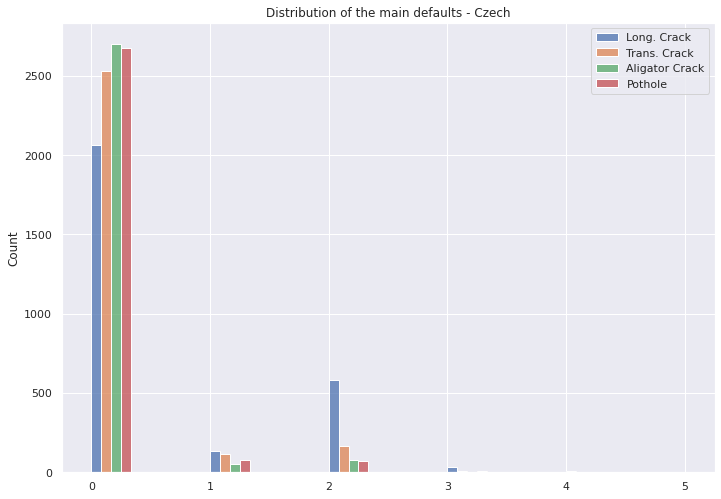

In [10]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(df_cz_cracks.iloc[:,1:5], multiple='dodge').set(title='Distribution of the main defaults - Czech');

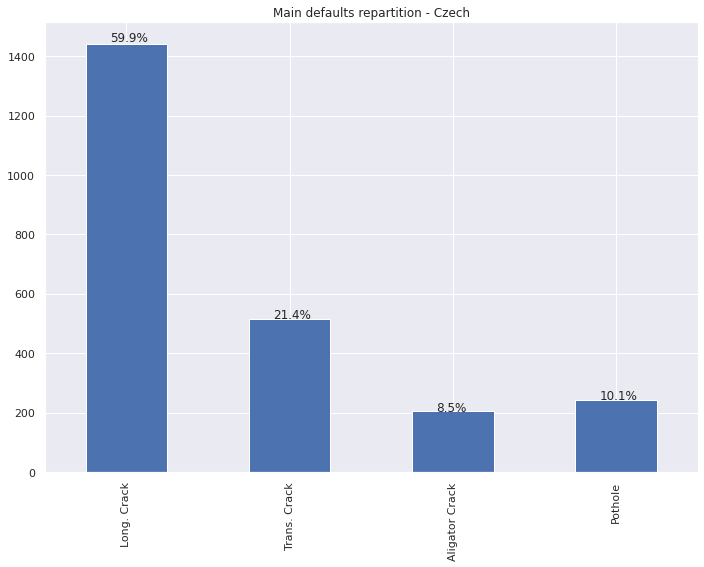

In [11]:
ax = df_cz_cracks.iloc[:,1:5].sum().plot.bar()
for p in ax.patches:
    ax.annotate(str(round(p.get_height() / df_cz_cracks.iloc[:,1:5].sum().sum() * 100,1)) + "%", (p.get_x() + 0.15, p.get_height() * 1.005))
plt.title("Main defaults repartition - Czech");

### 3.1.2. India

In [12]:
df_india_cracks = pd.DataFrame()

In [13]:
dir_list = os.listdir('train/India/annotations/xmls/')
l_countd40 = []
l_countd00 = []
l_countd10 = []
l_countd20 = []
image_name = []
for item in dir_list:
    with open(r'train/India/annotations/xmls/' + item + '', 'r') as f:
        data = f.read()
        countd40 = 0
        countd00 = 0
        countd10 = 0
        countd20 = 0
        d = xmltodict.parse(data)
        if 'object' in d['annotation']:
            for i in range(0, len(d['annotation']['object'])):
                if (len(d['annotation']['object']) >= 2) & (type(d['annotation']['object']) == list):
                    defect_type = d['annotation']['object'][i]['name']
                    if defect_type == 'D40':
                        countd40 += 1
                    elif defect_type == 'D00':
                        countd00 += 1
                    elif defect_type == 'D10':
                        countd10 += 1
                    elif defect_type == 'D20':
                        countd20 += 1
                else:
                    defect_type = d['annotation']['object']['name']
                    if defect_type == 'D40':
                        countd40 += 1
                    elif defect_type == 'D00':
                        countd00 += 1
                    elif defect_type == 'D10':
                        countd10 += 1
                    elif defect_type == 'D20':
                        countd20 += 1
        l_countd40.append(countd40)
        l_countd00.append(countd00)
        l_countd10.append(countd10)
        l_countd20.append(countd20)
        image_name.append(item)


df_india_cracks['file'] = image_name
df_india_cracks['Long. Crack'] = l_countd00
df_india_cracks['Trans. Crack'] = l_countd10
df_india_cracks['Aligator Crack'] = l_countd20
df_india_cracks['Pothole'] = l_countd40

In [14]:
df_india_cracks['Defaults'] = df_india_cracks.iloc[:,1:].sum(axis=1)
df_india_cracks['Defaults'].value_counts()

0     4483
5     1222
2      910
3      417
1      328
4      206
7       52
6       49
8       18
9       12
10       5
13       3
14       1
Name: Defaults, dtype: int64

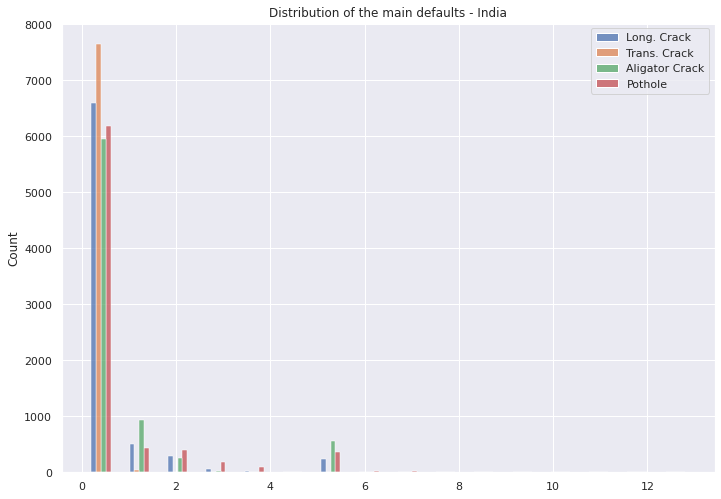

In [15]:
sns.histplot(df_india_cracks.iloc[:,1:5], multiple='dodge', shrink=0.5).set(title='Distribution of the main defaults - India');

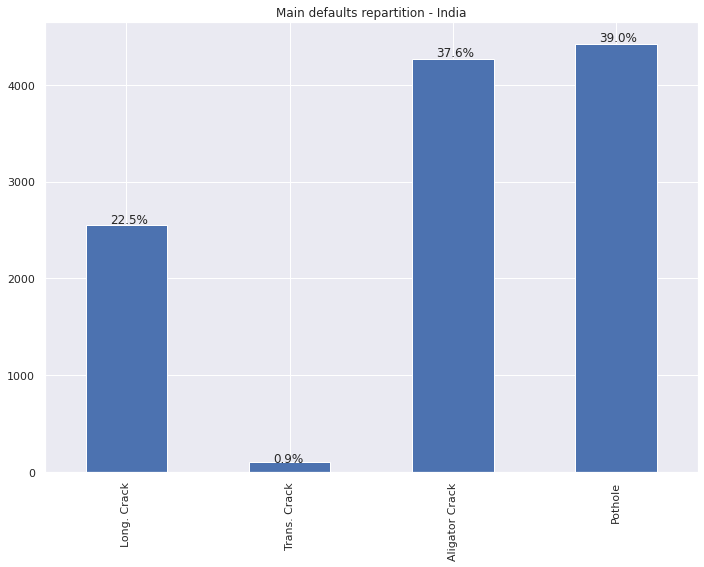

In [16]:
ax = df_india_cracks.iloc[:,1:5].sum().plot.bar()
for p in ax.patches:
    ax.annotate(str(round(p.get_height() / df_india_cracks.iloc[:,1:5].sum().sum() * 100,1)) + "%", (p.get_x() + 0.15, p.get_height() * 1.005))
plt.title("Main defaults repartition - India");

### 3.1.3. Japan

In [17]:
df_jp_cracks = pd.DataFrame()
dir_list = os.listdir('train/Japan/annotations/xmls/')
l_countd40 = []
l_countd00 = []
l_countd10 = []
l_countd20 = []
image_name = []
for item in dir_list:
    with open(r'train/Japan/annotations/xmls/' + item + '', 'r') as f:
        data = f.read()
        countd40 = 0
        countd00 = 0
        countd10 = 0
        countd20 = 0
        d = xmltodict.parse(data)
        if 'object' in d['annotation']:
            for i in range(0, len(d['annotation']['object'])):
                if (len(d['annotation']['object']) >= 2) & (type(d['annotation']['object']) == list):
                    defect_type = d['annotation']['object'][i]['name']
                    if defect_type == 'D40':
                        countd40 += 1
                    elif defect_type == 'D00':
                        countd00 += 1
                    elif defect_type == 'D10':
                        countd10 += 1
                    elif defect_type == 'D20':
                        countd20 += 1
                else:
                    defect_type = d['annotation']['object']['name']
                    if defect_type == 'D40':
                        countd40 += 1
                    elif defect_type == 'D00':
                        countd00 += 1
                    elif defect_type == 'D10':
                        countd10 += 1
                    elif defect_type == 'D20':
                        countd20 += 1
        l_countd40.append(countd40)
        l_countd00.append(countd00)
        l_countd10.append(countd10)
        l_countd20.append(countd20)
        image_name.append(item)


df_jp_cracks['file'] = image_name
df_jp_cracks['Long. Crack'] = l_countd00
df_jp_cracks['Trans. Crack'] = l_countd10
df_jp_cracks['Aligator Crack'] = l_countd20
df_jp_cracks['Pothole'] = l_countd40

In [18]:
df_jp_cracks['Defaults'] = df_jp_cracks.iloc[:,1:].sum(axis=1)
df_jp_cracks['Defaults'].value_counts()

0     2606
2     2316
5     1931
1     1720
3     1120
4      567
6      135
7       65
8       21
9       14
10       7
11       3
12       1
Name: Defaults, dtype: int64

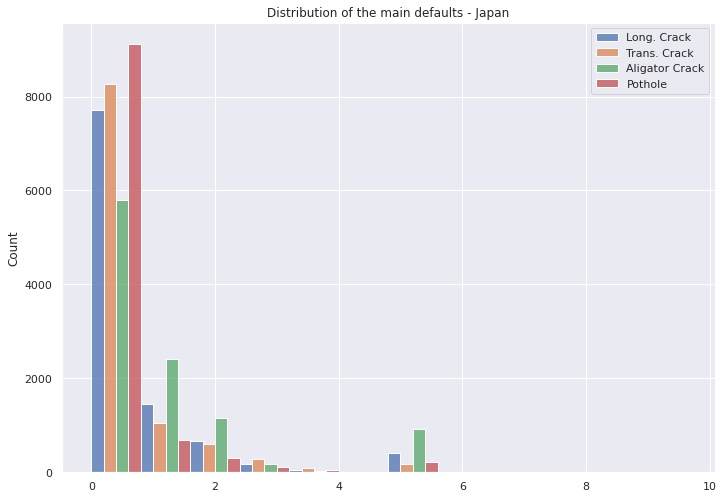

In [19]:
sns.histplot(df_jp_cracks.iloc[:,1:5], multiple='dodge',  binwidth=0.8).set(title='Distribution of the main defaults - Japan');

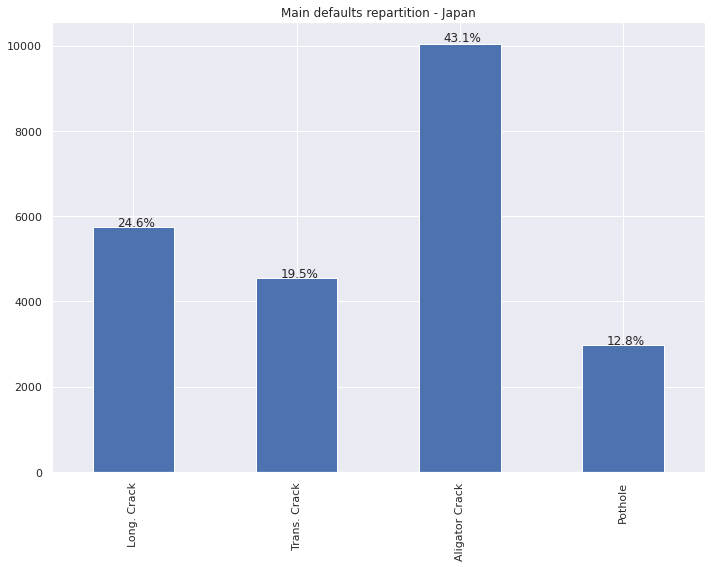

In [20]:
ax = df_jp_cracks.iloc[:,1:5].sum().plot.bar()
for p in ax.patches:
    ax.annotate(str(round(p.get_height() / df_jp_cracks.iloc[:,1:5].sum().sum() * 100,1)) + "%", (p.get_x() + 0.15, p.get_height() * 1.005))
plt.title("Main defaults repartition - Japan");

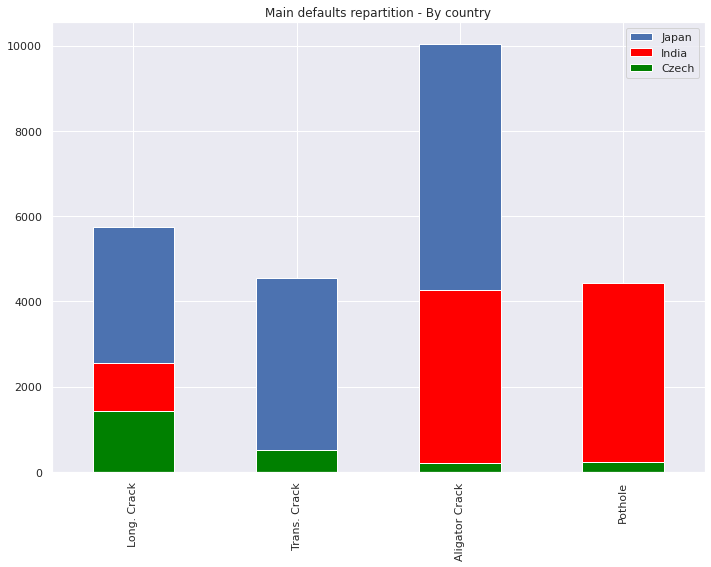

In [21]:
ax = df_jp_cracks.iloc[:,1:5].sum().plot.bar()
df_india_cracks.iloc[:,1:5].sum().plot.bar(ax=ax, color = "red")
df_cz_cracks.iloc[:,1:5].sum().plot.bar(ax=ax, color = "green")
ax.legend(["Japan", "India", "Czech"]);
plt.title("Main defaults repartition - By country");
plt.show()

## 3.2. All defaults distribution by country

### 3.2.1. Czech

In [22]:
df_cz_cracks = pd.DataFrame()

In [23]:
dir_list = os.listdir('train/Czech/annotations/xmls/')
l_countd40 = []
l_countd43 = []
l_countd00 = []
l_countd10 = []
l_countd20 = []
l_countd50 = []
l_countd0w0 = []
image_name = []
for item in dir_list:
    with open(r'train/Czech/annotations/xmls/' + item + '', 'r') as f:
        data = f.read()
        countd40 = 0
        countd43 = 0
        countd00 = 0
        countd10 = 0
        countd20 = 0
        countd50 = 0
        countd0w0 = 0
        d = xmltodict.parse(data)
        if 'object' in d['annotation']:
            for i in range(0, len(d['annotation']['object'])):
                if (len(d['annotation']['object']) >= 2) & (type(d['annotation']['object']) == list):
                    defect_type = d['annotation']['object'][i]['name']
                    if defect_type == 'D40':
                        countd40 += 1
                    elif defect_type == 'D00' or defect_type == 'D01':
                        countd00 += 1
                    elif defect_type == 'D10' or defect_type == 'D11':
                        countd10 += 1
                    elif defect_type == 'D20':
                        countd20 += 1
                    elif defect_type == 'D50':
                        countd50 += 1                    
                    elif defect_type == 'D0w0':
                        countd0w0 += 1
                    elif defect_type == 'D43' or defect_type == 'D44':
                        countd43 += 1
                else:
                    defect_type = d['annotation']['object']['name']
                    if defect_type == 'D40':
                        countd40 += 1
                    elif defect_type == 'D00':
                        countd00 += 1
                    elif defect_type == 'D10':
                        countd10 += 1
                    elif defect_type == 'D20':
                        countd20 += 1                    
                    elif defect_type == 'D50':
                        countd50 += 1
                    elif defect_type == 'D0w0':
                        countd0w0 += 1
                    elif defect_type == 'D43' or defect_type == 'D44':
                        countd43 += 1
        l_countd40.append(countd40)
        l_countd43.append(countd43)
        l_countd00.append(countd00)
        l_countd10.append(countd10)
        l_countd20.append(countd20)
        l_countd50.append(countd50)
        l_countd0w0.append(countd0w0)
        image_name.append(item)


df_cz_cracks['file'] = image_name
df_cz_cracks['Long. Crack'] = l_countd00
df_cz_cracks['Trans. Crack'] = l_countd10
df_cz_cracks['Aligator Crack'] = l_countd20
df_cz_cracks['Pothole'] = l_countd40  
df_cz_cracks['Manhole'] = l_countd50 
df_cz_cracks['White/Yellow Lines'] = l_countd43  
df_cz_cracks['Others'] = l_countd0w0 
df_cz_cracks.iloc[:,1:8].sum() 

Long. Crack           1441
Trans. Crack           515
Aligator Crack         205
Pothole                243
Manhole                  0
White/Yellow Lines       0
Others                   0
dtype: int64

In [24]:
df_cz_cracks['Defaults'] = df_cz_cracks.iloc[:,1:].sum(axis=1)
df_cz_cracks['Defaults'].value_counts()

0    1757
2     915
3      96
4      34
5      14
6      12
8       1
Name: Defaults, dtype: int64

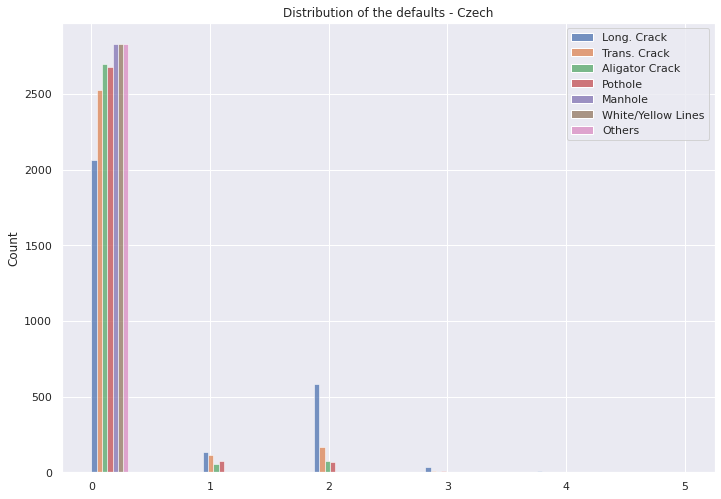

In [25]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(df_cz_cracks.iloc[:,1:8], multiple='dodge').set(title='Distribution of the defaults - Czech');

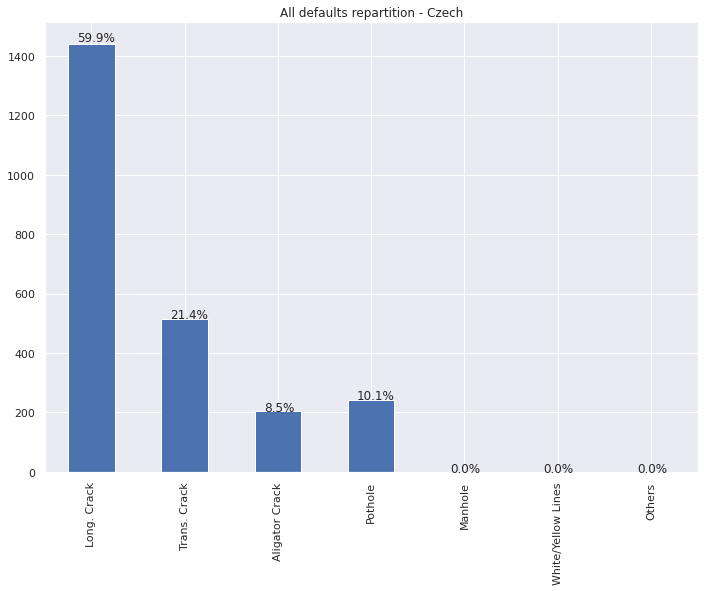

In [26]:
ax = df_cz_cracks.iloc[:,1:8].sum().plot.bar()
for p in ax.patches:
    ax.annotate(str(round(p.get_height() / df_cz_cracks.iloc[:,1:8].sum().sum() * 100,1)) + "%", (p.get_x() + 0.1, p.get_height() * 1.005))
plt.title("All defaults repartition - Czech");

### 3.1.2. India

In [27]:
df_india_cracks = pd.DataFrame()

In [28]:
dir_list = os.listdir('train/India/annotations/xmls/')
l_countd40 = []
l_countd43 = []
l_countd00 = []
l_countd10 = []
l_countd20 = []
l_countd50 = []
l_countd0w0 = []
image_name = []
for item in dir_list:
    with open(r'train/India/annotations/xmls/' + item + '', 'r') as f:
        data = f.read()
        countd40 = 0
        countd43 = 0
        countd00 = 0
        countd10 = 0
        countd20 = 0
        countd50 = 0
        countd0w0 = 0
        d = xmltodict.parse(data)
        if 'object' in d['annotation']:
            for i in range(0, len(d['annotation']['object'])):
                if (len(d['annotation']['object']) >= 2) & (type(d['annotation']['object']) == list):
                    defect_type = d['annotation']['object'][i]['name']
                    if defect_type == 'D40':
                        countd40 += 1
                    elif defect_type == 'D00' or defect_type == 'D01':
                        countd00 += 1
                    elif defect_type == 'D10' or defect_type == 'D11':
                        countd10 += 1
                    elif defect_type == 'D20':
                        countd20 += 1
                    elif defect_type == 'D50':
                        countd50 += 1                    
                    elif defect_type == 'D0w0':
                        countd0w0 += 1
                    elif defect_type == 'D43' or defect_type == 'D44':
                        countd43 += 1
                else:
                    defect_type = d['annotation']['object']['name']
                    if defect_type == 'D40':
                        countd40 += 1
                    elif defect_type == 'D00':
                        countd00 += 1
                    elif defect_type == 'D10':
                        countd10 += 1
                    elif defect_type == 'D20':
                        countd20 += 1                    
                    elif defect_type == 'D50':
                        countd50 += 1
                    elif defect_type == 'D0w0':
                        countd0w0 += 1
                    elif defect_type == 'D43' or defect_type == 'D44':
                        countd43 += 1
        l_countd40.append(countd40)
        l_countd43.append(countd43)
        l_countd00.append(countd00)
        l_countd10.append(countd10)
        l_countd20.append(countd20)
        l_countd50.append(countd50)
        l_countd0w0.append(countd0w0)
        image_name.append(item)


df_india_cracks['file'] = image_name
df_india_cracks['Long. Crack'] = l_countd00
df_india_cracks['Trans. Crack'] = l_countd10
df_india_cracks['Aligator Crack'] = l_countd20
df_india_cracks['Pothole'] = l_countd40  
df_india_cracks['Manhole'] = l_countd50 
df_india_cracks['White/Yellow Lines'] = l_countd43  
df_india_cracks['Others'] = l_countd0w0
df_india_cracks.iloc[:,1:8].sum() 

Long. Crack           2684
Trans. Crack           140
Aligator Crack        4269
Pothole               4423
Manhole                 68
White/Yellow Lines    2344
Others                   5
dtype: int64

In [29]:
df_india_cracks['Defaults'] = df_india_cracks.iloc[:,1:].sum(axis=1)
df_india_cracks['Defaults'].value_counts()

0     3975
5     1533
2     1237
3      535
4      273
7       57
6       57
8       17
9       13
10       5
13       3
14       1
Name: Defaults, dtype: int64

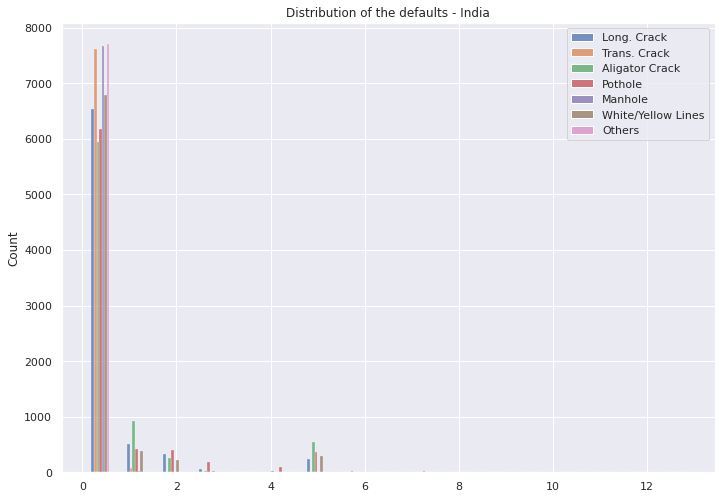

In [30]:
sns.histplot(df_india_cracks.iloc[:,1:8], multiple='dodge', shrink=0.5).set(title='Distribution of the defaults - India');

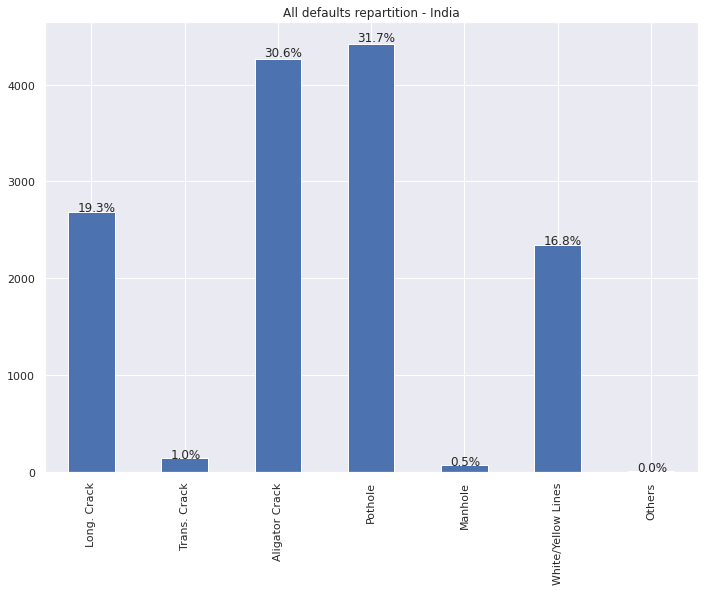

In [31]:
ax = df_india_cracks.iloc[:,1:8].sum().plot.bar()
for p in ax.patches:
    ax.annotate(str(round(p.get_height() / df_india_cracks.iloc[:,1:8].sum().sum() * 100,1)) + "%", (p.get_x() + 0.1, p.get_height() * 1.005))
plt.title("All defaults repartition - India");

### 3.1.3. Japan

In [32]:
df_jp_cracks = pd.DataFrame()
dir_list = os.listdir('train/Japan/annotations/xmls/')
l_countd40 = []
l_countd43 = []
l_countd00 = []
l_countd10 = []
l_countd20 = []
l_countd50 = []
l_countd0w0 = []
image_name = []
for item in dir_list:
    with open(r'train/Japan/annotations/xmls/' + item + '', 'r') as f:
        data = f.read()
        countd40 = 0
        countd43 = 0
        countd00 = 0
        countd10 = 0
        countd20 = 0
        countd50 = 0
        countd0w0 = 0
        d = xmltodict.parse(data)
        if 'object' in d['annotation']:
            for i in range(0, len(d['annotation']['object'])):
                if (len(d['annotation']['object']) >= 2) & (type(d['annotation']['object']) == list):
                    defect_type = d['annotation']['object'][i]['name']
                    if defect_type == 'D40':
                        countd40 += 1
                    elif defect_type == 'D00' or defect_type == 'D01':
                        countd00 += 1
                    elif defect_type == 'D10' or defect_type == 'D11':
                        countd10 += 1
                    elif defect_type == 'D20':
                        countd20 += 1
                    elif defect_type == 'D50':
                        countd50 += 1                    
                    elif defect_type == 'd0w0':
                        countd0w0 += 1
                    elif defect_type == 'D43' or defect_type == 'D44':
                        countd43 += 1
                else:
                    defect_type = d['annotation']['object']['name']
                    if defect_type == 'D40':
                        countd40 += 1
                    elif defect_type == 'D00':
                        countd00 += 1
                    elif defect_type == 'D10':
                        countd10 += 1
                    elif defect_type == 'D20':
                        countd20 += 1                    
                    elif defect_type == 'D50':
                        countd50 += 1
                    elif defect_type == 'd0w0':
                        countd0w0 += 1
                    elif defect_type == 'D43' or defect_type == 'D44':
                        countd43 += 1
        l_countd40.append(countd40)
        l_countd43.append(countd43)
        l_countd00.append(countd00)
        l_countd10.append(countd10)
        l_countd20.append(countd20)
        l_countd50.append(countd50)
        l_countd0w0.append(countd0w0)
        image_name.append(item)


df_jp_cracks['file'] = image_name
df_jp_cracks['Long. Crack'] = l_countd00
df_jp_cracks['Trans. Crack'] = l_countd10
df_jp_cracks['Aligator Crack'] = l_countd20
df_jp_cracks['Pothole'] = l_countd40  
df_jp_cracks['Manhole'] = l_countd50 
df_jp_cracks['White/Yellow Lines'] = l_countd43  
df_jp_cracks['Others'] = l_countd0w0
df_jp_cracks.iloc[:,1:8].sum() 

Long. Crack            5738
Trans. Crack           4548
Aligator Crack        10041
Pothole                2982
Manhole                4665
White/Yellow Lines     6486
Others                    0
dtype: int64

In [33]:
df_jp_cracks['Defaults'] = df_jp_cracks.iloc[:,1:].sum(axis=1)
df_jp_cracks['Defaults'].value_counts()

2     3485
5     2810
3     1797
4     1057
0      794
6      315
7      143
8       57
9       21
10      17
11       6
12       3
13       1
Name: Defaults, dtype: int64

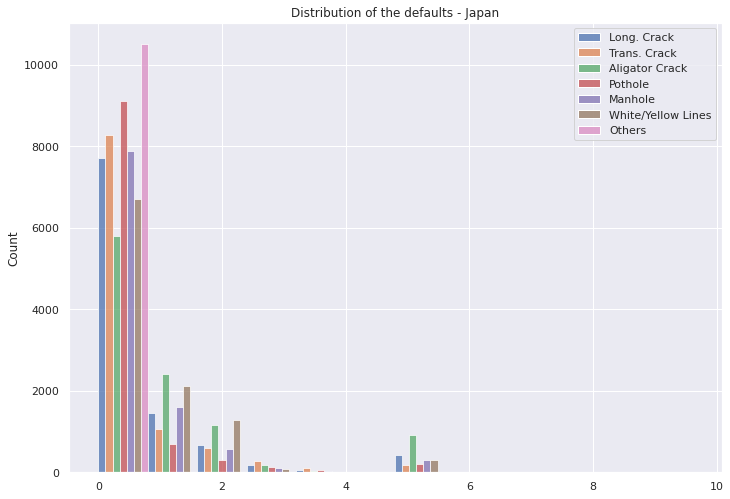

In [34]:
sns.histplot(df_jp_cracks.iloc[:,1:8], multiple='dodge',  binwidth=0.8).set(title='Distribution of the defaults - Japan');

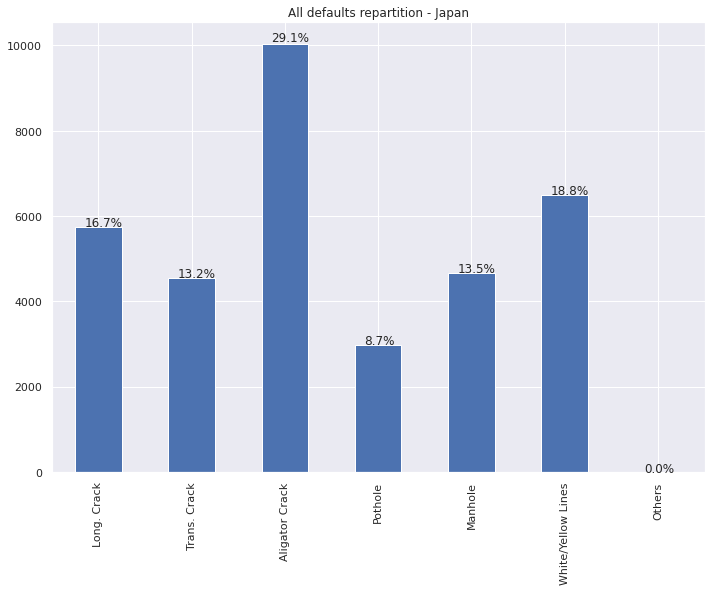

In [35]:
ax = df_jp_cracks.iloc[:,1:8].sum().plot.bar()
for p in ax.patches:
    ax.annotate(str(round(p.get_height() / df_jp_cracks.iloc[:,1:8].sum().sum() * 100,1)) + "%", (p.get_x() + 0.1, p.get_height() * 1.005))
plt.title("All defaults repartition - Japan");

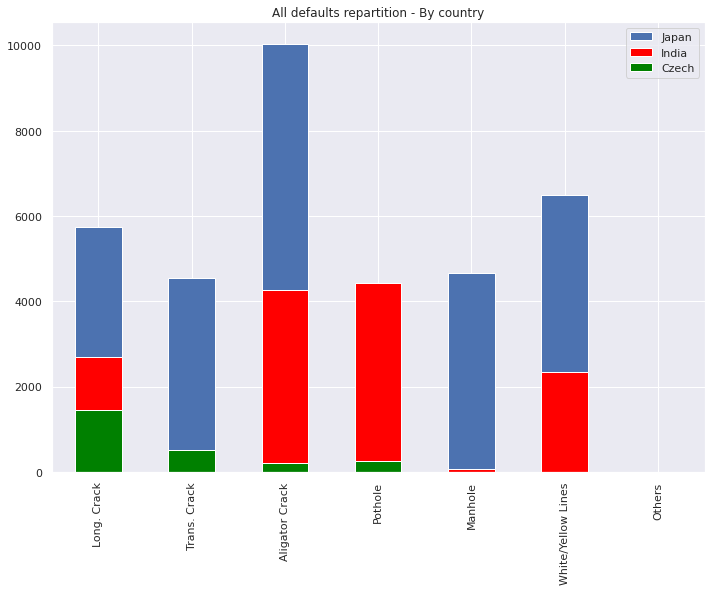

In [36]:
ax = df_jp_cracks.iloc[:,1:8].sum().plot.bar()
df_india_cracks.iloc[:,1:8].sum().plot.bar(ax=ax, color = "red")
df_cz_cracks.iloc[:,1:8].sum().plot.bar(ax=ax, color = "green")
ax.legend(["Japan", "India", "Czech"]);
plt.title("All defaults repartition - By country");
plt.show()